## Example Experiment ##
### Dataset: Labeled Faces in the Wild ###
### Experiment: Two party training for gender classification ###

In [1]:
import simulator.server as server
import simulator.workerclass as worker
import simulator.workerhandler as wh
import topology_utils as tu

from collections import OrderedDict
import pandas as pd
import numpy as np
import copy
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sattvik/envs/pytorch_env/lib/py

## Parameters ##

In [2]:
epochs = 20
# epochs = 2
batch_size = 64
learning_rate = 0.001
server_learning_rate = 0.05
num_workers = 2
local_iterations = 2

data_path = '../data/lfw/data/'

# default `log_dir` is "runs" - we'll be more specific here
!rm -rf ./runs/experiment_2
writer = SummaryWriter('runs/experiment_2')

## Divide Data between workers ##

In [3]:
attributes_df = pd.read_csv(data_path+'lfw_attributes.txt')

all_names = attributes_df.person.unique()
tt_msk = np.random.rand(len(all_names)) < 0.8
temp_train_names = all_names[tt_msk]
test_names = all_names[~tt_msk]
del all_names, tt_msk
train_val_df = attributes_df.loc[attributes_df['person'].isin(temp_train_names)]
test_df = attributes_df.loc[attributes_df['person'].isin(test_names)]

# add column to indicate split
train_val_df['target'] = 0
# allocate half the people to the target
names = train_val_df['person'].drop_duplicates()
target_worker_names = names.sample(frac=1)[:int(len(names)/2)]
target_worker_names = target_worker_names.reset_index(drop=True)

# populate target field
for index, row in train_val_df.iterrows():
    if row['person'] in target_worker_names.values:
        train_val_df['target'][index] = 1

# print distribution of data
print("entries with worker 1: {}, entries with worker 2: {}, entries in training set: {}, total entries: {}".format(sum(train_val_df['target']==1), sum(train_val_df['target']==0), len(test_df), len(attributes_df)))

/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

entries with worker 1: 5166, entries with worker 2: 5545, entries in training set: 2432, total entries: 13143


## Define dataset class ##

In [4]:
class LFWDataset(Dataset):
    """LFW dataset."""

    def __init__(self, data_path, attributes_df, transform=None):
        self.attributes_df = attributes_df
        self.data_path = data_path
        self.transform = transform

    def __len__(self):
        return len(self.attributes_df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_path, "lfw_home/lfw_funneled", self.attributes_df.iloc[idx]['person'].replace(' ', '_'),"{}_{:04d}.jpg".format(self.attributes_df.iloc[idx]['person'].replace(' ', '_'),self.attributes_df.iloc[idx]['imagenum']))
#         img = torch.from_numpy(cv2.imread(img_path))
        img = Image.open(img_path, mode='r')
        
        label = self.attributes_df.iloc[idx]['Male']>0
        
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float)

## Define Model ##

In [5]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool1 = nn.MaxPool2d(4,4)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.pool2 = nn.MaxPool2d(4,4)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.pool3 = nn.MaxPool2d(2,2)
#         self.conv4 = nn.Conv2d(32, 32, 5)
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout_layer1 = nn.Dropout(p=0.6)
        self.dropout_layer2 = nn.Dropout(p=0.5)
#         self.dropout_layer3 = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
#         x = F.relu(self.conv4(x))
        x = x.view(x.shape[0],-1)
        x = self.dropout_layer1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout_layer2(x)
#         x = self.dropout_layer3(x)
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

def define_model():
    return ResNet()

## Training, Validation, and Evaluation functions ##

In [6]:
def perform_evaluation(val_model, dataloader):
    with torch.no_grad():
        epoch_loss = 0
        epoch_accuracy = 0
        for batch_idx, (data, target) in tqdm_notebook(enumerate(dataloader), total=len(dataloader)):
            # move data batch to GPU
            data = data.cuda()
            target = target.cuda()
            # forward pass
            output = val_model(data)
            loss = F.binary_cross_entropy(output, target.unsqueeze(1))
            # compute average loss an accuracy
            output = output.to('cpu')
            target = target.to('cpu')
            current_acc = torch.tensor(((output>0.5)== torch.tensor(target.unsqueeze(1), dtype=torch.bool)).sum(), dtype=torch.float)/torch.tensor(len(target), dtype=torch.float)
            epoch_loss = ((epoch_loss*batch_idx) + loss.item())/(batch_idx+1)
            epoch_accuracy = ((epoch_accuracy*batch_idx) + current_acc.item())/(batch_idx+1)
    print("testing loss: {} and testing accuracy: {}".format(epoch_loss, epoch_accuracy))
    return epoch_loss, epoch_accuracy

In [7]:
def perform_validation(val_model, dataloader):
    with torch.no_grad():
        epoch_loss = 0
        epoch_accuracy = 0
        for batch_idx, (data, target) in tqdm_notebook(enumerate(dataloader), total=len(dataloader)):
            # move data batch to GPU
            data = data.cuda()
            target = target.cuda()
            # forward pass
            output = val_model(data)
#             print(output, target.unsqueeze(1))
            loss = F.binary_cross_entropy(output, target.unsqueeze(1))
            # compute average loss an accuracy
            output = output.to('cpu')
            target = target.to('cpu')
            current_acc = torch.tensor(((output>0.5)== torch.tensor(target.unsqueeze(1), dtype=torch.bool)).sum(), dtype=torch.float)/torch.tensor(len(target), dtype=torch.float)
            epoch_loss = ((epoch_loss*batch_idx) + loss.item())/(batch_idx+1)
            epoch_accuracy = ((epoch_accuracy*batch_idx) + current_acc.item())/(batch_idx+1)
    print("val loss: {} and val accuracy: {}".format(epoch_loss, epoch_accuracy))
    return epoch_loss, epoch_accuracy

In [8]:
def perform_training(val_model, dataloader, optimizer):
    epoch_loss = 0
    epoch_accuracy = 0
    for batch_idx, (data, target) in tqdm_notebook(enumerate(dataloader), total=len(dataloader)):
        # move data batch to GPU
        data = data.cuda()
        target = target.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        output = val_model(data)
        loss = F.binary_cross_entropy(output, target.unsqueeze(1))
        # backward pass
        loss.backward()
        optimizer.step()
        # compute average loss an accuracy
        output = output.to('cpu')
        target = target.to('cpu')
        current_acc = torch.tensor(((output>0.5)== torch.tensor(target.unsqueeze(1), dtype=torch.bool)).sum(), dtype=torch.float)/torch.tensor(len(target), dtype=torch.float)
        epoch_loss = ((epoch_loss*batch_idx) + loss.item())/(batch_idx+1)
        epoch_accuracy = ((epoch_accuracy*batch_idx) + current_acc.item())/(batch_idx+1)
    print("train loss: {} and train accuracy: {}".format(epoch_loss, epoch_accuracy))
    return epoch_loss, epoch_accuracy

## Declare genuine worker ##

In [9]:
class target_worker(worker.base_workerclass):
    def __init__(self, name, attributes_df, model):
        super().__init__(name, False)
        self.worker_attributes_df = attributes_df[attributes_df['target']==1]
        print("initializing genuine worker node with ",len(self.worker_attributes_df)," data points")
        self.model = model
        self.local_iters = local_iterations
        # train val split
        all_names = self.worker_attributes_df.person.unique()
        tt_msk = np.random.rand(len(all_names)) < 0.8
        train_names = all_names[tt_msk]
        val_names = all_names[~tt_msk]
        del all_names, tt_msk
        
        # set optimizer
        self.set_optim()
        # create train val and test dataframes
        train_df = self.worker_attributes_df.loc[self.worker_attributes_df['person'].isin(train_names)]
        val_df = self.worker_attributes_df.loc[self.worker_attributes_df['person'].isin(val_names)]
        
        train_dataset = LFWDataset(data_path, train_df, transform=transforms.Compose([
#                                                     transforms.RandomResizedCrop(224),
                                                    transforms.RandomHorizontalFlip(),
                                                    transforms.ToTensor()
                                                    ]))
        val_dataset = LFWDataset(data_path, val_df, transform=transforms.Compose([
#                                                             transforms.RandomResizedCrop(224),
                                                            transforms.RandomHorizontalFlip(),
                                                            transforms.ToTensor()]))
        del train_df, val_df
        
        self.train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        print(len(self.train_dataloader), len(self.val_dataloader))
    
    def set_param(self, w):
        self.model.load_state_dict(w)
    
    def get_params(self):
        return self.model.state_dict()
    
    def set_optim(self):
        self.optim = optim.Adam(self.model.parameters(), lr=learning_rate)
    
    def client_update(self, global_epoch):
        global writer
        self.model = self.model.cuda()
        prev_w = copy.deepcopy(self.model.state_dict())
        # unfreeze layers
#         if 5 == global_epoch:
#             self.model.unfreeze_layer3()
#         if 20 == global_epoch:
#             self.model.unfreeze_layer2()
#         if 50 == global_epoch:
#             self.model.unfreeze_layer1()
        for epoch in range(self.local_iters):
            # run train and val epochs
            print("sub-epoch: {}".format(epoch))
            self.model.train()
            train_loss, train_acc = perform_training(self.model, self.train_dataloader, self.optim)
            writer.add_scalar('training loss_'+self.name, train_loss, (global_epoch*self.local_iters)+epoch)
            writer.add_scalar('training accuracy_'+self.name, train_acc, (global_epoch*self.local_iters)+epoch)
            self.model.eval()
            val_loss, val_acc = perform_validation(self.model, self.val_dataloader)
            writer.add_scalar('validation loss_'+self.name, val_loss, (global_epoch*self.local_iters)+epoch)
            writer.add_scalar('validation accuracy_'+self.name, val_acc, (global_epoch*self.local_iters)+epoch)
        graddif = OrderedDict()
        for (item1, item2) in zip(self.model.state_dict().items(),prev_w.items()):
            key1=item1[0]
            value1=item1[1]
            key2=item2[0]
            value2=item2[1]
            diffval = value1-value2
            graddif.update({key1:diffval.cpu()})
        self.model = self.model.cpu()
        return graddif

## Declare malicious worker ##

In [10]:
# class malicious_worker(worker.base_workerclass):
#     def __init__(self, attributes_df, model):
#         super().__init__(True)
#         self.worker_attributes_df = attributes_df[attributes_df['target']==0]
#         print("initializing malicious worker node with ",len(self.worker_attributes_df)," data points")
#         self.model = model
#         self.local_iters = 5
    
#     def set_param(self, w):
#         self.model.load_state_dict(w)
    
#     def set_optim(self):
#         self.optim = optim.Adam(self.model.parameters(), lr=learning_rate)
    
#     def client_update(self):
#         print('ss')

## Initialize components of our simulations ##

In [11]:
server1 = server.server(server_learning_rate)
workers = wh.workerhandler([target_worker("w1", train_val_df,define_model()),target_worker("w2", train_val_df,define_model())])

initializing genuine worker node with  5166  data points
67 15
initializing genuine worker node with  5166  data points
68 14


In [12]:
tm = tu.topology_manager()

## Define network topology ##

In [13]:
tm.connect_star(server1, workers.get_all_workers())

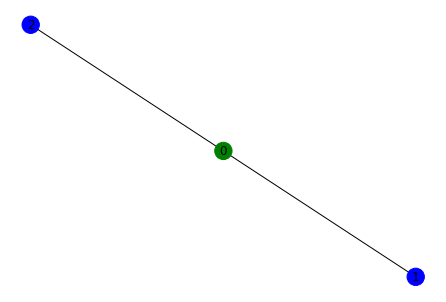

In [14]:
plot = tm.plot_topology()

## Start Training ##

In [15]:
# initialize server weights as model average
server1.set_init_weights(workers.get_average_weights())

# start training
for epoch in range(epochs):
    print("Epoch: ", epoch)
    new_grad = workers.perform_updates(epoch)
    new_w = server1.aggregate(new_grad)
    workers.set_param(new_w)

Epoch:  0
training on worker:  w1
sub-epoch: 0


/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



train loss: 0.5481701617810264 and train accuracy: 0.7548196520378343


/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()



val loss: 0.5890263080596922 and val accuracy: 0.6865196069081624
sub-epoch: 1



train loss: 0.46947945587670625 and train accuracy: 0.7751865671641792



val loss: 0.4829630215962728 and val accuracy: 0.7227328419685364
training on worker:  w2
sub-epoch: 0



train loss: 0.5421908287441031 and train accuracy: 0.7554818803773207



val loss: 0.58200090272086 and val accuracy: 0.7247362009116581
sub-epoch: 1



train loss: 0.4500833206317004 and train accuracy: 0.785313813125386



val loss: 0.49645509677273886 and val accuracy: 0.7903814954417092
Epoch:  1
training on worker:  w1
sub-epoch: 0



train loss: 0.5599667065179167 and train accuracy: 0.7263681595005206



val loss: 0.6217775285243988 and val accuracy: 0.683762256304423
sub-epoch: 1



train loss: 0.4817738982278909 and train accuracy: 0.770677860993058



val loss: 0.48993596037228904 and val accuracy: 0.6865196069081624
training on worker:  w2
sub-epoch: 0



train loss: 0.5701143908150057 and train accuracy: 0.7142397586037131



val loss: 0.5870975255966187 and val accuracy: 0.7247362009116581
sub-epoch: 1



train loss: 0.5226086816366982 and train accuracy: 0.7640231093939613



val loss: 0.5306063911744526 and val accuracy: 0.7139813303947449
Epoch:  2
training on worker:  w1
sub-epoch: 0



train loss: 0.6052794309694376 and train accuracy: 0.6468439057691772



val loss: 0.6315509637196859 and val accuracy: 0.6828431367874146
sub-epoch: 1



train loss: 0.5382503142107778 and train accuracy: 0.7716884328358209



val loss: 0.6370219190915426 and val accuracy: 0.6846813718477885
training on worker:  w2
sub-epoch: 0



train loss: 0.5922529977910661 and train accuracy: 0.6708508405615303



val loss: 0.5904170147010258 and val accuracy: 0.7139813303947449
sub-epoch: 1



train loss: 0.4981909403029609 and train accuracy: 0.7640231093939613



val loss: 0.501716239111764 and val accuracy: 0.7193587677819389
Epoch:  3
training on worker:  w1
sub-epoch: 0



train loss: 0.5911701406115917 and train accuracy: 0.6755286072617146



val loss: 0.6223857561747234 and val accuracy: 0.685600491364797
sub-epoch: 1



train loss: 0.5372031197619083 and train accuracy: 0.7716884328358209



val loss: 0.6091679573059082 and val accuracy: 0.685600491364797
training on worker:  w2
sub-epoch: 0



train loss: 0.6159381932195496 and train accuracy: 0.6203387607546413



val loss: 0.5872396400996617 and val accuracy: 0.7301136382988521
sub-epoch: 1



train loss: 0.5514962839729647 and train accuracy: 0.762880777611452



val loss: 0.5826130253928048 and val accuracy: 0.7193587677819389
Epoch:  4
training on worker:  w1
sub-epoch: 0



train loss: 0.6370393909625153 and train accuracy: 0.5856654225890318



val loss: 0.620978057384491 and val accuracy: 0.683762256304423
sub-epoch: 1



train loss: 0.5437006429949802 and train accuracy: 0.7737095774109684



val loss: 0.6330143094062806 and val accuracy: 0.6828431367874146
training on worker:  w2
sub-epoch: 0



train loss: 0.6412686850218212 and train accuracy: 0.5730764182174907



val loss: 0.6201911568641663 and val accuracy: 0.7139813303947449
sub-epoch: 1



train loss: 0.5559903076466393 and train accuracy: 0.7636423321331248



val loss: 0.6252838862793786 and val accuracy: 0.7193587677819389
Epoch:  5
training on worker:  w1
sub-epoch: 0



train loss: 0.5853369529567548 and train accuracy: 0.6735074626865674



val loss: 0.6372789760430654 and val accuracy: 0.683762256304423
sub-epoch: 1



train loss: 0.5369944874920062 and train accuracy: 0.771688432835821



val loss: 0.6356217662493387 and val accuracy: 0.683762256304423
training on worker:  w2
sub-epoch: 0



train loss: 0.6246205555165517 and train accuracy: 0.6149356619400137



val loss: 0.6014517588274819 and val accuracy: 0.7139813303947449
sub-epoch: 1



train loss: 0.5480627167750808 and train accuracy: 0.7632615548722884



val loss: 0.6011123699801308 and val accuracy: 0.7139813303947449
Epoch:  6
training on worker:  w1
sub-epoch: 0



train loss: 0.6259521939861242 and train accuracy: 0.561489428157237



val loss: 0.6878443837165833 and val accuracy: 0.6846813718477885
sub-epoch: 1



train loss: 0.5436737252705133 and train accuracy: 0.7716884328358209



val loss: 0.6112401366233826 and val accuracy: 0.6865196069081624
training on worker:  w2
sub-epoch: 0



train loss: 0.6580959707498553 and train accuracy: 0.5128413868301055



val loss: 0.6143063860280173 and val accuracy: 0.7247362009116581
sub-epoch: 1



train loss: 0.5607152011464623 and train accuracy: 0.7642134980243797



val loss: 0.5893311479261943 and val accuracy: 0.7139813303947449
Epoch:  7
training on worker:  w1
sub-epoch: 0



train loss: 0.5898651996655251 and train accuracy: 0.6587375624855952



val loss: 0.6190873781840005 and val accuracy: 0.6828431367874146
sub-epoch: 1



train loss: 0.5398920102795558 and train accuracy: 0.771688432835821



val loss: 0.6143500606218973 and val accuracy: 0.6828431367874146
training on worker:  w2
sub-epoch: 0



train loss: 0.6871242163812413 and train accuracy: 0.46271008428405314



val loss: 0.6301884055137634 and val accuracy: 0.7139813303947449
sub-epoch: 1



train loss: 0.5620640476836877 and train accuracy: 0.7636423321331248



val loss: 0.6286876159054893 and val accuracy: 0.7032264620065689
Epoch:  8
training on worker:  w1
sub-epoch: 0



train loss: 0.692027572375625 and train accuracy: 0.4704601987084346



val loss: 0.6470709522565206 and val accuracy: 0.6846813718477885
sub-epoch: 1



train loss: 0.5529977394573726 and train accuracy: 0.7686567164179102



val loss: 0.6502321481704711 and val accuracy: 0.6828431367874146
training on worker:  w2
sub-epoch: 0



train loss: 0.6985103750930113 and train accuracy: 0.42180278371362123



val loss: 0.6829066830021995 and val accuracy: 0.7247362009116581
sub-epoch: 1



train loss: 0.6486713167499093 and train accuracy: 0.7630711662418702



val loss: 0.6016283759049007 and val accuracy: 0.7139813303947449
Epoch:  9
training on worker:  w1
sub-epoch: 0



train loss: 0.7017856222480091 and train accuracy: 0.3799751240815689



val loss: 0.6877944032351176 and val accuracy: 0.6800857861836751
sub-epoch: 1



train loss: 0.6715071459314716 and train accuracy: 0.7716884328358209



val loss: 0.6698538462320963 and val accuracy: 0.685600491364797
training on worker:  w2
sub-epoch: 0



train loss: 0.7020402778597441 and train accuracy: 0.36003807800657617



val loss: 0.6866145815168109 and val accuracy: 0.7139813303947449
sub-epoch: 1



train loss: 0.6018147170543672 and train accuracy: 0.7640231093939613



val loss: 0.5936922941889081 and val accuracy: 0.7247362009116581
Epoch:  10
training on worker:  w1
sub-epoch: 0



train loss: 0.6460665802457437 and train accuracy: 0.5015547266646997



val loss: 0.7196820338567098 and val accuracy: 0.6865196069081624
sub-epoch: 1



train loss: 0.5537526727612339 and train accuracy: 0.7716884328358209



val loss: 0.6465637445449829 and val accuracy: 0.681924021244049
training on worker:  w2
sub-epoch: 0



train loss: 0.6290671132943209 and train accuracy: 0.5828847166369943



val loss: 0.6047359449522836 and val accuracy: 0.7032264620065689
sub-epoch: 1



train loss: 0.5581308427978963 and train accuracy: 0.7632615548722884



val loss: 0.6251908711024693 and val accuracy: 0.7086038972650256
Epoch:  11
training on worker:  w1
sub-epoch: 0



train loss: 0.7065037631276826 and train accuracy: 0.32322761194029853



val loss: 0.6814117709795634 and val accuracy: 0.6865196069081624
sub-epoch: 1



train loss: 0.572147970324132 and train accuracy: 0.7706778609930579



val loss: 0.6287568370501201 and val accuracy: 0.685600491364797
training on worker:  w2
sub-epoch: 0



train loss: 0.7011831017101512 and train accuracy: 0.32231486369581785



val loss: 0.6002726469721112 and val accuracy: 0.7247362009116581
sub-epoch: 1



train loss: 0.5613246704725657 and train accuracy: 0.763832720763543



val loss: 0.6054294151919228 and val accuracy: 0.7193587677819389
Epoch:  12
training on worker:  w1
sub-epoch: 0



train loss: 0.7108305879493256 and train accuracy: 0.25031094497709133



val loss: 0.6915923992792765 and val accuracy: 0.6846813718477885
sub-epoch: 1



train loss: 0.5908824316601256 and train accuracy: 0.7747201492537313



val loss: 0.6358402887980144 and val accuracy: 0.6828431367874146
training on worker:  w2
sub-epoch: 0



train loss: 0.7105633598916671 and train accuracy: 0.2365480569355628



val loss: 0.6933040406022754 and val accuracy: 0.2860186696052551
sub-epoch: 1



train loss: 0.6815579051480574 and train accuracy: 0.7555606619400137



val loss: 0.673194774559566 and val accuracy: 0.7247362009116581
Epoch:  13
training on worker:  w1
sub-epoch: 0



train loss: 0.6211243814496852 and train accuracy: 0.6022232584099272



val loss: 0.6154465754826862 and val accuracy: 0.6874387264251709
sub-epoch: 1



train loss: 0.5379596552742063 and train accuracy: 0.7726990046785839



val loss: 0.6386724670728048 and val accuracy: 0.685600491364797
training on worker:  w2
sub-epoch: 0



train loss: 0.7114859591512119 and train accuracy: 0.27949711154488954



val loss: 0.6785803437232971 and val accuracy: 0.7139813303947449
sub-epoch: 1



train loss: 0.5800806678393308 and train accuracy: 0.7630711662418703



val loss: 0.5999424244676318 and val accuracy: 0.7139813303947449
Epoch:  14
training on worker:  w1
sub-epoch: 0



train loss: 0.665972815075917 and train accuracy: 0.4537468908438042



val loss: 0.6211545209089915 and val accuracy: 0.6901960770289103
sub-epoch: 1



train loss: 0.5395419241777105 and train accuracy: 0.7706778609930579



val loss: 0.6131632486979167 and val accuracy: 0.681924021244049
training on worker:  w2
sub-epoch: 0



train loss: 0.6649337090990123 and train accuracy: 0.45160189095665426



val loss: 0.6081454498427254 and val accuracy: 0.7086038972650256
sub-epoch: 1



train loss: 0.5574856737957281 and train accuracy: 0.7636423321331248



val loss: 0.6315747414316449 and val accuracy: 0.7301136382988521
Epoch:  15
training on worker:  w1
sub-epoch: 0



train loss: 0.7151753551034785 and train accuracy: 0.33302238805970147



val loss: 0.6551816821098329 and val accuracy: 0.6846813718477885
sub-epoch: 1



train loss: 0.5679973199296353 and train accuracy: 0.7716884328358209



val loss: 0.6243421117464701 and val accuracy: 0.6828431367874146
training on worker:  w2
sub-epoch: 0



train loss: 0.6999240600887466 and train accuracy: 0.39400604016640595



val loss: 0.6396428516932896 and val accuracy: 0.7139813303947449
sub-epoch: 1



train loss: 0.5497833827839178 and train accuracy: 0.7636423321331248



val loss: 0.5853728268827709 and val accuracy: 0.7139813303947449
Epoch:  16
training on worker:  w1
sub-epoch: 0



train loss: 0.7612804565856707 and train accuracy: 0.2262904229226397



val loss: 0.6968033234278361 and val accuracy: 0.31256127456823984
sub-epoch: 1



train loss: 0.6349146117025348 and train accuracy: 0.6647232584099272



val loss: 0.6329026261965434 and val accuracy: 0.6828431367874146
training on worker:  w2
sub-epoch: 0



train loss: 0.7165319560205236 and train accuracy: 0.41181066194001364



val loss: 0.6542873638016837 and val accuracy: 0.7139813303947449
sub-epoch: 1



train loss: 0.5586535124217764 and train accuracy: 0.7623096117201973



val loss: 0.5743744777781623 and val accuracy: 0.7301136382988521
Epoch:  17
training on worker:  w1
sub-epoch: 0



train loss: 0.7474670303401663 and train accuracy: 0.6208022388059704



val loss: 0.6287879029909769 and val accuracy: 0.685600491364797
sub-epoch: 1



train loss: 0.5466008346472211 and train accuracy: 0.7696672882606734



val loss: 0.6193885087966919 and val accuracy: 0.6865196069081624
training on worker:  w2
sub-epoch: 0



train loss: 0.8361305866171332 and train accuracy: 0.23578650219475522



val loss: 0.6985632308891842 and val accuracy: 0.27526379908834187
sub-epoch: 1



train loss: 0.6675662521053763 and train accuracy: 0.6548450633006939



val loss: 0.5923468619585037 and val accuracy: 0.7193587677819389
Epoch:  18
training on worker:  w1
sub-epoch: 0



train loss: 1.0781831643474633 and train accuracy: 0.2262904229226397



val loss: 0.6986753821372986 and val accuracy: 0.31164215703805287
sub-epoch: 1



train loss: 0.686162266268659 and train accuracy: 0.6185478852755988



val loss: 0.676805579662323 and val accuracy: 0.6828431367874146
training on worker:  w2
sub-epoch: 0



train loss: 1.060235758914667 and train accuracy: 0.2674763658467461



val loss: 0.6816360439573016 and val accuracy: 0.7354910714285714
sub-epoch: 1



train loss: 0.5817406628938282 and train accuracy: 0.761876313125386



val loss: 0.5821985134056636 and val accuracy: 0.7247362009116581
Epoch:  19
training on worker:  w1
sub-epoch: 0



train loss: 36.962626457214355 and train accuracy: 0.2262904229226397



val loss: 0.718960988521576 and val accuracy: 0.3162377456823985
sub-epoch: 1



train loss: 0.6178563579694548 and train accuracy: 0.6075870643800764



val loss: 0.6314334313074748 and val accuracy: 0.6773284316062927
training on worker:  w2
sub-epoch: 0



train loss: 41.82719028697294 and train accuracy: 0.23597689082517342



val loss: 5.420692716326032 and val accuracy: 0.29139610486371176
sub-epoch: 1



train loss: 0.7112489312010652 and train accuracy: 0.5846047795870725



val loss: 0.5895734024899346 and val accuracy: 0.7247362009116581


## Evaluate Model ##

In [16]:
# evaluate final model
eval_model = define_model()
eval_model.load_state_dict(new_w)
eval_model.eval()
eval_model = eval_model.cuda()
torch.save(eval_model.state_dict(), "models/experiment2_model.pt")

test_dataset = LFWDataset(data_path, test_df, transform=transforms.Compose([
#                                                     transforms.RandomResizedCrop(224),
                                                    transforms.RandomHorizontalFlip(),
                                                    transforms.ToTensor()
                                                    ]))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_loss, test_acc = perform_evaluation(eval_model, test_dataloader)

/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app



testing loss: 24.101716141951712 and testing accuracy: 0.21751644736842105
